<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
## Uncomment 3 dòng sau nếu dùng colab
# !pip install -q condacolab
# import condacolab
# condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.12
    Uninstalling SQLAlchemy-2.0.12:
      Successfully uninstalled SQLAlchemy-2.0.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.49 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 50.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7


<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
df.shape

(97013, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.496293,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,42.488071,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.437027,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.934700,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.496293,493729600.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,6.496293,6.496293,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,42.488071,5277400.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,42.488071,42.488071,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.437027,6894300.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,33.437027,33.437027,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777546,6186700.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,43.777546,43.777546,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.934700,7325600.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,40.934700,40.934700,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,17.134521,59853700.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,17.134521,17.134521,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,46.397530,10173800.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,46.397530,46.397530,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.933924,13700400.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,27.933924,27.933924,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,138.805939,9135000.0,0.0,0.0,6.517797,6.486023,100.0,66.666667,100.0,138.805939,138.805939,20.040001,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2010-01-01 to 2021-10-01

Trading data period: 2021-10-01 to 2023-03-01


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,381.613617,3779900.0,3.0,-4.331477,417.498441,385.282178,40.895410,-222.899711,41.980385,404.287856,403.780895,23.139999,24.872204
2956,2021-09-30,V,227.580002,228.789993,222.630005,219.829178,7128500.0,3.0,-1.535733,228.194394,216.108269,44.078982,-54.593421,19.569853,224.339918,231.029017,23.139999,24.872204
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,48.149590,18736600.0,3.0,-0.229558,49.249516,47.886784,41.824926,-102.691157,21.682953,48.732631,49.248955,23.139999,24.872204
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.298752,6449400.0,3.0,-0.249741,47.804739,42.944107,44.613721,-107.261088,0.941150,45.199112,44.185760,23.139999,24.872204
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,135.599686,7485900.0,3.0,-1.548949,145.602011,135.119855,40.165785,-151.532152,45.466733,141.806628,140.712199,23.139999,24.872204


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.208939,94639600.0,4.0,-1.701135,155.168225,136.942766,46.927724,-142.198323,41.749873,146.968512,146.067375,21.1,120.123099
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,201.940552,2629400.0,4.0,-3.068379,210.779241,197.515985,40.408569,-96.817084,36.189244,206.532159,215.074075,21.1,120.123099
0,2021-10-01,AXP,168.500000,175.119995,168.479996,169.484177,3956000.0,4.0,2.265561,173.623478,148.722895,56.265107,117.513395,15.667511,160.664718,162.900276,21.1,120.123099
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123099
0,2021-10-01,CAT,192.899994,195.869995,191.240005,186.913452,3695500.0,4.0,-3.620670,204.625188,180.453260,41.999437,-112.106516,36.203176,195.930333,199.439523,21.1,120.123099


In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
env_kwargs_ensemble = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
print(np.unique(buy_cost_list))
print(np.unique(sell_cost_list))

[0.001]
[0.001]


## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


In [ ]:
import torch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")
if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 45          |
|    iterations         | 100         |
|    time_elapsed       | 11          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41         |
|    explained_variance | 0.318       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -14.2       |
|    reward             | -0.92799145 |
|    std                | 0.996       |
|    value_loss         | 0.427       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 52        |
|    iterations         | 200       |
|    time_elapsed       | 18        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41       |
|    explained_variance | 0.555     |
|    learning_rate

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4659623.11
total_reward: 3659623.11
total_cost: 1107.77
total_trades: 53208
Sharpe: 0.835
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 51        |
|    time_elapsed    | 231       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 19.2      |
|    critic_loss     | 1.6e+03   |
|    learning_rate   | 0.001     |
|    n_updates       | 8871      |
|    reward          | -8.045765 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 49        |
|    time_elapsed    | 479       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | -17       |
|    critic_loss     | 5.18      |
|    learning_rate   | 0.001     |
|    n_updates       | 20699     |


### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 65         |
|    iterations      | 1          |
|    time_elapsed    | 31         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.67029905 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 64         |
|    iterations           | 2          |
|    time_elapsed         | 63         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01486473 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.0139    |
|    learning_rate        | 0.00025    |
|    loss                 | 6.68       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0311    |
|    reward         

### Ensemble

In [ ]:
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent

In [ ]:
env_kwargs_ensemble = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                **env_kwargs_ensemble)



In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007,
                    'device': 'cuda'
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128,
                    'device': 'cuda'
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64,
                      'device': 'cuda'
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [ ]:
df_summary_ensemble = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.71847654801218


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007, 'device': 'cuda'}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2
---------------------------------------
| time/                 |             |
|    fps                | 58          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -21.2       |
|    reward             | 0.116917275 |
|    std                | 0.999       |
|    value_loss         | 0.586       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 60          |
|    iterations        

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 57         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 1.79e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -14.7      |
|    reward             | 0.22077939 |
|    std                | 1          |
|    value_loss         | 0.751      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 59        |
|    iterations         | 200       |
|    time_elapsed       | 16        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -0.149    |
|    learning_rate      | 0.0007  

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 59         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0.217      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -42.6      |
|    reward             | 0.10092637 |
|    std                | 1          |
|    value_loss         | 1.73       |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 59           |
|    iterations         | 200          |
|    time_elapsed       | 16           |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -41.2        |
|    explained_variance | 0.332        |
|    le

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 59         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -92.8      |
|    reward             | -0.6518055 |
|    std                | 0.995      |
|    value_loss         | 10         |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 59        |
|    iterations         | 200       |
|    time_elapsed       | 16        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

In [ ]:
df_summary_ensemble

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,DDPG,0.150905,0.241175,0.252364
1,189,2022-01-03,2022-04-04,A2C,-0.001616,-0.106716,-0.210397
2,252,2022-04-04,2022-07-06,DDPG,-0.205207,-0.197884,-0.196614
3,315,2022-07-06,2022-10-04,A2C,-0.030819,-0.193349,-0.091872


### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 52        |
|    time_elapsed    | 225       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 13.2      |
|    critic_loss     | 253       |
|    learning_rate   | 0.001     |
|    n_updates       | 8871      |
|    reward          | -7.059142 |
----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 4999661.24
total_reward: 3999661.24
total_cost: 1205.54
total_trades: 35520
Sharpe: 0.856
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 50        |
|    time_elapsed    | 467       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 4.75      |
|    critic_loss     | 63.7      |
|    learning_rate   | 0.001     |
|    n_updates       | 20699     |


### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 37        |
|    time_elapsed    | 311       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 137       |
|    critic_loss     | 98.9      |
|    ent_coef        | 0.0719    |
|    ent_coef_loss   | -109      |
|    learning_rate   | 0.0001    |
|    n_updates       | 11727     |
|    reward          | -9.257149 |
----------------------------------
day: 2956, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 5023907.51
total_reward: 4023907.51
total_cost: 7562.27
total_trades: 54107
Sharpe: 0.873
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 38         |
|    time_elapsed    | 622        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 39.8       |
|    critic_loss     | 57.1

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold

Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139584
std        43.879094
min         0.000000
25%        14.613465
50%        23.644434
75%        38.292571
max       652.505560
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

291.725051926576

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.208939,94639600.0,4.0,-1.701135,155.168225,136.942766,46.927724,-142.198323,41.749873,146.968512,146.067375,21.1,120.123099
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,201.940552,2629400.0,4.0,-3.068379,210.779241,197.515985,40.408569,-96.817084,36.189244,206.532159,215.074075,21.1,120.123099
0,2021-10-01,AXP,168.500000,175.119995,168.479996,169.484177,3956000.0,4.0,2.265561,173.623478,148.722895,56.265107,117.513395,15.667511,160.664718,162.900276,21.1,120.123099
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123099
0,2021-10-01,CAT,192.899994,195.869995,191.240005,186.913452,3695500.0,4.0,-3.620670,204.625188,180.453260,41.999437,-112.106516,36.203176,195.930333,199.439523,21.1,120.123099


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [ ]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.496293
1,2010-01-04,AMGN,42.488071
2,2010-01-04,AXP,33.437027
3,2010-01-04,BA,43.777546
4,2010-01-04,CAT,40.934700


In [ ]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [ ]:
mvo.shape[0]

3310

### Helper functions

In [ ]:
from scipy import optimize
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

  #dependencies


  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

  return res

def MinimizeRisk(CovarReturns, PortfolioSize):

  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T)
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b
    return constraintVal

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

  def  f(x,CovarReturns):

    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq
    return EqconstraintVal

  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal


  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

  return opt

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [ ]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[147.81158447, 196.99398804, 176.75291443, ...,  47.88248444,
         44.45829773, 144.7155304 ],
       [147.34634399, 195.01158142, 173.90065002, ...,  47.47655106,
         43.36317062, 143.52859497],
       [151.02874756, 195.56852722, 170.55996704, ...,  47.62989807,
         43.34476852, 144.42367554],
       ...,
       [149.19363403, 235.3989563 , 173.89724731, ...,  37.23613358,
         35.66752625, 140.97447205],
       [146.50735474, 231.47598267, 173.01356506, ...,  37.4390831 ,
         35.26366806, 141.35150146],
       [147.71568298, 232.2585907 , 172.07029724, ...,  37.57437897,
         34.85981369, 140.32957458]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.051]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.635]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.645]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.603]
 [1.371 1.066 1.907

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([268510.,      0.,      0.,      0.,      0.,  67170.,      0.,
            0.,      0.,      0., 328490.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        80330.,      0.,      0., 249920.,   5570.,      0.,      0.,
            0.])

In [ ]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,147.138474,196.002792,178.08136,212.869995,195.56662,293.920013,52.246513,106.639702,172.009995,396.094025,...,77.315521,303.287811,161.191147,135.731201,155.574799,438.991425,230.813248,47.431446,45.295742,145.98999


In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1824.88 ,    0.   ,    0.   ,    0.   ,    0.   ,  228.532,
          0.   ,    0.   ,    0.   ,    0.   ,  924.01 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  498.352,    0.   ,    0.   ,
        569.305,   24.132,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.002272e+06
2021-10-27,1.002461e+06
2021-10-28,1.011236e+06
2021-10-29,1.010909e+06
2021-11-01,1.001450e+06
...,...
2023-02-21,9.195315e+05
2023-02-22,9.194654e+05
2023-02-23,9.249119e+05
2023-02-24,9.120101e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
df_account_value_a2c

,date,account_value
0,2021-10-01,1.000000e+06
1,2021-10-04,9.976519e+05
2,2021-10-05,1.003355e+06
3,2021-10-06,1.005336e+06
4,2021-10-07,1.016254e+06
...,...,...
348,2023-02-21,1.029201e+06
349,2023-02-22,1.026483e+06
350,2023-02-23,1.028497e+06
351,2023-02-24,1.020256e+06


In [ ]:
unique_trade_date = processed[(processed.date > TRADE_START_DATE)&(processed.date <= TRADE_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [ ]:


df_account_value_ensemble=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    print(temp)
    df_account_value_ensemble = pd.concat([df_account_value_ensemble, temp],ignore_index=True)
sharpe_ensemble=(252**0.5)*df_account_value_ensemble.account_value.pct_change(1).mean()/df_account_value_ensemble.account_value.pct_change(1).std()
print('Sharpe Ratio of ensemble strategy: ',sharpe_ensemble)
df_account_value_ensemble=df_account_value_ensemble.join(df_trade_date[validation_window:].reset_index(drop=True))

     account_value        date  daily_return
0   1000000.000000  2022-01-03           NaN
1    999632.128493  2022-01-04     -0.000368
2    990830.946835  2022-01-05     -0.008804
3    982759.870574  2022-01-06     -0.008146
4    983434.283713  2022-01-07      0.000686
..             ...         ...           ...
58   974896.445065  2022-03-28      0.003124
59   982742.720094  2022-03-29      0.008048
60   981175.070206  2022-03-30     -0.001595
61   964924.555177  2022-03-31     -0.016562
62   969602.831767  2022-04-01      0.004848

[63 rows x 3 columns]
    account_value        date  daily_return
0   975134.216922  2022-04-04           NaN
1   968364.417341  2022-04-05     -0.006942
2   965041.009818  2022-04-06     -0.003432
3   968811.522827  2022-04-07      0.003907
4   969587.815272  2022-04-08      0.000801
..            ...         ...           ...
58  876909.318374  2022-06-28     -0.013119
59  883433.818021  2022-06-29      0.007440
60  876425.434133  2022-06-30     -0.0079

In [ ]:
df_account_value_ensemble

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999632.128493,2022-01-04,-0.000368,2022-01-04
2,990830.946835,2022-01-05,-0.008804,2022-01-05
3,982759.870574,2022-01-06,-0.008146,2022-01-06
4,983434.283713,2022-01-07,0.000686,2022-01-07
...,...,...,...,...
247,972045.668243,2022-12-27,0.001557,2022-12-27
248,960899.117793,2022-12-28,-0.011467,2022-12-28
249,965931.621111,2022-12-29,0.005237,2022-12-29
250,961209.963738,2022-12-30,-0.004888,2022-12-30


In [ ]:
df_result_ensemble = pd.DataFrame({'date': df_account_value_ensemble['date'], 'account_value': df_account_value_ensemble['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')


In [ ]:
df_result_ensemble

,account_value
date,
2022-01-03,1000000.000000
2022-01-04,999632.128493
2022-01-05,990830.946835
2022-01-06,982759.870574
2022-01-07,983434.283713
...,...
2022-12-27,972045.668243
2022-12-28,960899.117793
2022-12-29,965931.621111


In [ ]:
df_account_value_a2c = df_account_value_a2c[(df_account_value_a2c['date'] >= '2022-01-03') & (df_account_value_a2c['date'] <= '2023-01-03')]
df_account_value_ddpg = df_account_value_ddpg[(df_account_value_ddpg['date'] >= '2022-01-03') & (df_account_value_ddpg['date'] <= '2023-01-03')]
df_account_value_td3 = df_account_value_td3[(df_account_value_td3['date'] >= '2022-01-03') & (df_account_value_td3['date'] <= '2023-01-03')]
df_account_value_ppo = df_account_value_ppo[(df_account_value_ppo['date'] >= '2022-01-03') & (df_account_value_ppo['date'] <= '2023-01-03')]
df_account_value_sac = df_account_value_sac[(df_account_value_sac['date'] >= '2022-01-03') & (df_account_value_sac['date'] <= '2023-01-03')]

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])

In [ ]:
df_result_a2c

,account_value
date,
2022-01-03,1.125662e+06
2022-01-04,1.131490e+06
2022-01-05,1.121370e+06
2022-01-06,1.111028e+06
2022-01-07,1.100586e+06
...,...
2022-12-27,1.040080e+06
2022-12-28,1.029199e+06
2022-12-29,1.038410e+06


In [ ]:
sharpe_a2c=(252**0.5)*df_account_value_a2c.account_value.pct_change(1).mean()/df_account_value_a2c.account_value.pct_change(1).std()

sharpe_ppo=(252**0.5)*df_account_value_ppo.account_value.pct_change(1).mean()/df_account_value_ppo.account_value.pct_change(1).std()
sharpe_ddpg=(252**0.5)*df_account_value_ddpg.account_value.pct_change(1).mean()/df_account_value_ddpg.account_value.pct_change(1).std()
sharpe_td3=(252**0.5)*df_account_value_td3.account_value.pct_change(1).mean()/df_account_value_td3.account_value.pct_change(1).std()
sharpe_sac=(252**0.5)*df_account_value_sac.account_value.pct_change(1).mean()/df_account_value_sac.account_value.pct_change(1).std()


In [ ]:
print('Sharpe Ratio of ensemble strategy: ',sharpe_ensemble)
print('Sharpe Ratio of a2c strategy: ',sharpe_a2c)
print('Sharpe Ratio of ppo strategy: ',sharpe_ppo)
print('Sharpe Ratio of ddpg strategy: ',sharpe_ddpg)
print('Sharpe Ratio of td3 strategy: ',sharpe_td3)
print('Sharpe Ratio of sac strategy: ',sharpe_sac)


Sharpe Ratio of ensemble strategy:  -0.07051984782941285
Sharpe Ratio of a2c strategy:  -0.3344602790160211
Sharpe Ratio of ppo strategy:  -0.31195460211615644
Sharpe Ratio of ddpg strategy:  0.04265963853111936
Sharpe Ratio of td3 strategy:  -0.3992695001136532
Sharpe Ratio of sac strategy:  -0.1299084317919971


In [ ]:

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('_a', '_b'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
result = pd.merge(result, MVO_result, left_index=True, right_index=True)
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('_c', '_d'))
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji', 'ensemble']

print("result: ", result)
result.to_csv("result.csv")


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
2022-01-03  1.125662e+06  1.088568e+06  1.058592e+06  1.052159e+06   
2022-01-04  1.131490e+06  1.096097e+06  1.056443e+06  1.056925e+06   
2022-01-05  1.121370e+06  1.089541e+06  1.038743e+06  1.045994e+06   
2022-01-06  1.111028e+06  1.081981e+06  1.028734e+06  1.043319e+06   
2022-01-07  1.100586e+06  1.078196e+06  1.031092e+06  1.045592e+06 

/opt/conda/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


<Figure size 1500x500 with 0 Axes>

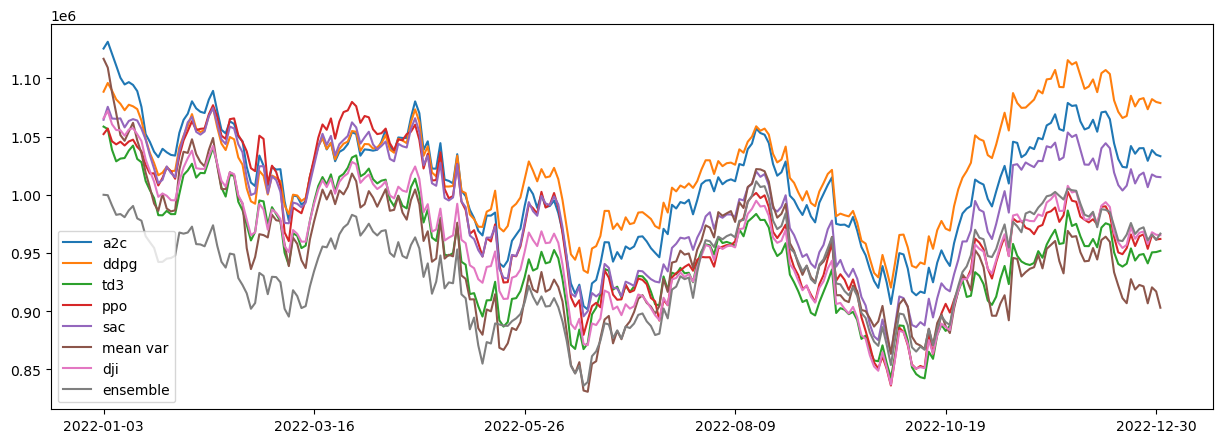

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [ ]:
!zip -r '/kaggle/working/datasets.zip' '/kaggle/working/datasets'

  adding: kaggle/working/datasets/ (stored 0%)
